# IBTrACS Data

The IBTrACS, or International Best Track Archive for Climate Stewardship (IBTrACS) data contains a history of tropical storm data. It is stored by [NOAA's National Climatic Data Center (NCDC)](https://www.ncdc.noaa.gov/ibtracs/). Let's load the data and explore it in Python.

## Import Modules

Let's start by importing the modules we need.

In [1]:
import urllib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Download the Data

Now we need to download the IBTrACS data. It isn't very large, so it shouldn't take too long.

In [2]:
# Set the URL
url = 'https://www.ncei.noaa.gov/data/'+\
      'international-best-track-archive-for-climate-stewardship-ibtracs/'+\
      'v04r00/access/csv/ibtracs.NA.list.v04r00.csv'

# Set the file path
filePath = './data/ibtracs_NA.csv'

# Download the file if it doesn't already exists
if not os.path.exists(filePath):
    urllib.request.urlretrieve(url,filePath)

## Explore the Data

There are a lot of variables here, but we will only need a handful. Some of the pertinent variables and their descriptions are provided below (from the IBTrACS documentation):

Variable Name | Description
--- | ---
`numobs` | the number of observations for each storm
`sid` | a unique storm identifier (SID) assigned by IBTrACS algorithm
`season` | year the storm began
`number` | number of the storm for the year (restarts at 1 for each year)
`basin` | basin of the current storm position
`subbasin` | sub-basin of the current storm position
`name` | name of system give by source (if available)
`iso_time` | time of the observation in ISO format (YYYY-MM-DD hh:mm:ss)
`nature` | type of storm (a combination of the various types from the available sources)
`lat` | mean position - latitude (a combination of the available positions)
`lon` | mean position - longitude (a combination of the available positions)
`wmo_wind` | maximum sustained wind speed assigned by the responsible WMO agency
`wmo_pres` | minimum central pressure assigned by the responsible WMO agnecy
`track_type` | track type (main or spur). 
`dist2land` | current distance to land from current position
`landfall` | minimum distance to land over next 3 hours (=0 means landfall)
`iflag` | a flag identifying the type of interpolation used to fill the value at the given time
`storm_speed` | storm translation speed (knots)
`storm_dir` | storm translation direction (in degrees east of north)

We won't necessarily keep all of these, but it's good to know what these are. Now let's read in the data and have a look at the last few values.

In [3]:
# Read the data from the CSV
df = pd.read_csv(filePath,low_memory=False,skiprows=range(1,2))

# Only keep a handful of columns
keepColumns = ['SID','SEASON','NUMBER','NAME','ISO_TIME',
               'NATURE','LAT','LON','WMO_WIND','WMO_PRES','TRACK_TYPE',
               'DIST2LAND','LANDFALL','IFLAG','STORM_SPEED','STORM_DIR']
df = df[keepColumns]

# Convert time strings to datetimes for better querying
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])
df['SEASON'] = pd.to_numeric(df['SEASON'])
df['NUMBER'] = pd.to_numeric(df['NUMBER'])
df['LAT'] = pd.to_numeric(df['LAT'])
df['LON'] = pd.to_numeric(df['LON'])

# Show the last few records
df.tail()

,SID,SEASON,NUMBER,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,STORM_SPEED,STORM_DIR
122457,2020277N13293,2020,84,DELTA,2020-10-11 12:00:00,ET,34.9000,-87.2000,,,PROVISIONAL,0,0,O_____________,10,60
122458,2020277N13293,2020,84,DELTA,2020-10-11 15:00:00,ET,35.1470,-86.6508,,,PROVISIONAL,0,0,P_____________,9,72
122459,2020277N13293,2020,84,DELTA,2020-10-11 18:00:00,ET,35.2000,-86.1000,,,PROVISIONAL,0,0,O_____________,10,102
122460,2020277N13293,2020,84,DELTA,2020-10-11 21:00:00,ET,34.9433,-85.5103,,,PROVISIONAL,0,0,P_____________,12,125
122461,2020277N13293,2020,84,DELTA,2020-10-12 00:00:00,ET,34.5000,-84.9000,,,PROVISIONAL,0,,O_____________,13,131


We can query the dataframe to make data analysis a bit easier. For example, let's see how many named storms are in the entire dataset.

In [4]:
df[df['NAME'] !='NOT_NAMED'].groupby(['SEASON', 'NAME']).size()

SEASON  NAME   
1950    ABLE       100
        BAKER      116
        CHARLIE    121
        DOG        147
        EASY        73
                  ... 
2020    RENE        75
        SALLY       63
        TEDDY      111
        VICKY       51
        WILFRED     51
Length: 776, dtype: int64

We can also query seasons. Let's see the unique named storms this year.

In [5]:
df[(df['SEASON']==2020) & (df['NAME']!='NOT_NAMED')]['NAME'].unique().tolist()

['ARTHUR',
 'BERTHA',
 'AMANDA:CRISTOBAL',
 'DOLLY',
 'EDOUARD',
 'FAY',
 'GONZALO',
 'HANNA',
 'ISAIAS',
 'JOSEPHINE',
 'KYLE',
 'GENEVIEVE',
 'MARCO',
 'LAURA',
 'OMAR',
 'NANA',
 'PAULETTE',
 'RENE',
 'TEDDY',
 'SALLY',
 'VICKY',
 'WILFRED',
 'ALPHA',
 'BETA',
 'GAMMA',
 'DELTA']

## Accumulated Cyclone Energy

Let's explore the data a bit more. Accumulated Cyclone Energy (ACE) is defined as the cummulative kinetic energy over the season for every six hours when the winds of above 35 knots. As these numbers are often quite large, they are scaled down by a factor of 10000. Let's subset the whole IBTrACS to six-hourly data which winds below this threshold. It's a little more nuanced than what I'm doing here, but it's still roughly the same idea.

In [6]:
df = df[df['ISO_TIME'].dt.hour.isin([0,6,12,18])]
df["WMO_WIND"] = pd.to_numeric(df[df['WMO_WIND']!=" "]["WMO_WIND"])
df = df[df["WMO_WIND"]>=35]

Now let's subset the data and calculate the ACE based on the formula.

In [7]:
years = [i for i in range(1850,2020)]
ace = [(df[df["SEASON"]==year]['WMO_WIND']**2).sum()/10000. for year in years]

And now we can plot the results.

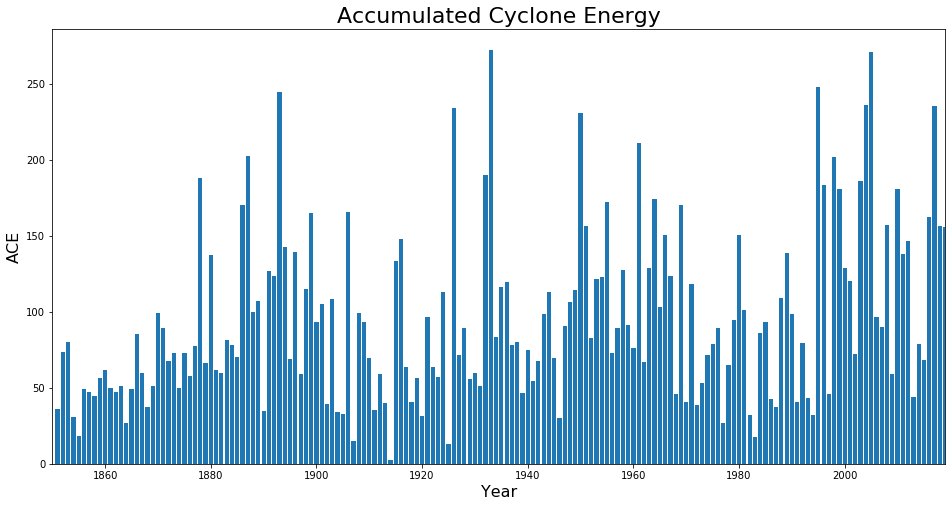

In [8]:
fig,ax = plt.subplots(figsize=(16,8));
ax.bar(years,ace);
ax.set_xlabel("Year",fontsize=16);
ax.set_ylabel("ACE",fontsize=16);
ax.set_title("Accumulated Cyclone Energy",fontsize=22);
ax.set_xlim(min(years),max(years));

Let's have a look at the years with the largest ACE.

In [9]:
aceSorted = sorted(ace,reverse=True)
yearsSorted = [year for _,year in sorted(zip(ace,years),reverse=True)]
for aceValue,year in zip(aceSorted[:10],yearsSorted[:10]):
    print("Year",year,"\t Ace:",aceValue)

Year 1933 	 Ace: 272.635
Year 2005 	 Ace: 271.1
Year 1995 	 Ace: 248.14
Year 1893 	 Ace: 244.5925
Year 2004 	 Ace: 235.9775
Year 2017 	 Ace: 235.735
Year 1926 	 Ace: 234.5325
Year 1950 	 Ace: 231.21
Year 1961 	 Ace: 210.8725
Year 1887 	 Ace: 202.505


Now, just because I'm curious, let's plot the "Accumulated Accumulated Cyclon Energy" (AACE). Basically, take all of ACE values and sum them up from the beginning of the data. If there is a large enough increase of ACE in the latest years, then we should see a notable increase in the slope of the AACE.

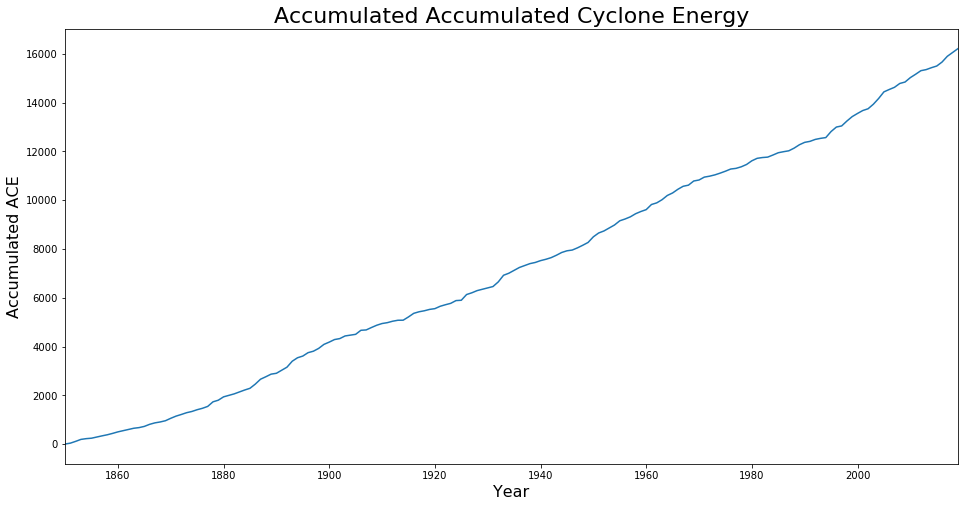

In [10]:
fig,ax = plt.subplots(figsize=(16,8));
ax.plot(years,np.cumsum(ace));
ax.set_xlabel("Year",fontsize=16);
ax.set_ylabel("Accumulated ACE",fontsize=16);
ax.set_title("Accumulated Accumulated Cyclone Energy",fontsize=22);
ax.set_xlim(min(years),max(years));

At first glance, there's not an obvious uptick in the slope. It does seem to be more positive in the last 20 to 30 years, but there are other increases and decreases in the slope throughout the years.